# Reservoir geometry

## About this document

This document was generated from an R markdown file on `r as.character(Sys.time())`.

In [1]:
from cinterop.timeseries import xr_ts_start, xr_ts_end
from swift2.doc_helper import configure_hourly_gr4j, define_parameteriser_gr4j_muskingum, sample_catchment_model, sample_series
from swift2.simulation import swap_model
from swift2.utils import mk_full_data_id
from swift2.vis import plot_two_series

## Model structure

Setting up this model is not the primary purpose of this vignette, so you may skip this section.

In [2]:
# swiftr_dev()

In [3]:
catchmentStructure = sample_catchment_model(site_id = "Adelaide", config_id = "catchment")

hydromodel = "GR4J"
channel_routing = 'MuskingumNonLinear'
hydroModelRainfallId = 'P'
hydroModelEvapId = 'E'

# set models
insimulation = swap_model(catchmentStructure, model_id = hydromodel ,what = "runoff")
simulation = swap_model(insimulation, model_id = channel_routing ,what = "channel_routing")

saId = simulation.get_subarea_ids()
assert len(saId) == 1

precipTs = sample_series(site_id = "Adelaide", var_name = "rain")
evapTs = sample_series(site_id = "Adelaide", var_name = "evap")
flowRateTs = sample_series(site_id = "Adelaide", var_name = "flow")

In [4]:
mk_full_data_id('subarea', saId, hydroModelRainfallId)

['subarea.1.P']

In [5]:
simulation.play_input(precipTs, mk_full_data_id('subarea', saId, hydroModelRainfallId))
simulation.play_input(evapTs, mk_full_data_id('subarea', saId, hydroModelEvapId))
configure_hourly_gr4j(simulation)
simulation.set_simulation_time_step('hourly')

# Small time interval only, to reduce runtimes in this vignette

from uchronia.time_series import mk_date
simstart = mk_date(2010,9,1)  
simend = mk_date(2012,6,30,23)  
simwarmup = simstart
simulation.set_simulation_span(simstart, simend)

In [6]:
def templateHydroParameterizer(simulation):
    return define_parameteriser_gr4j_muskingum(ref_area=250.0,
        time_span=3600,
        simulation=simulation,
        objfun="NSE",
        delta_t=1.0,
        param_name_k='Alpha')


nodeId = 'node.2'
flowId = mk_full_data_id(nodeId, 'OutflowRate')

simulation.record_state(flowId)

We use pre-calibrated hydrologic parameters 

In [7]:
p = templateHydroParameterizer(simulation)
p.set_min_parameter_value('R0', 0.0)
p.set_max_parameter_value('R0', 1.0)
p.set_min_parameter_value('S0', 0.0)
p.set_max_parameter_value('S0', 1.0)
p.set_parameter_value('log_x4', 1.017730e+00)
p.set_parameter_value('log_x1', 2.071974e+00	)
p.set_parameter_value('log_x3', 1.797909e+00	)
p.set_parameter_value('asinh_x2', -1.653842e+00)	
p.set_parameter_value('R0', 2.201930e-11	)
p.set_parameter_value('S0', 3.104968e-11	)
p.set_parameter_value('X', 6.595537e-03	) # Gotcha: needs to be set before alpha is changed.
p.set_parameter_value('Alpha', 6.670534e-01	)
p

       Name         Value       Min       Max
0    log_x4  1.017730e+00  0.000000  2.380211
1    log_x1  2.071974e+00  0.000000  3.778151
2    log_x3  1.797909e+00  0.000000  3.000000
3  asinh_x2 -1.653842e+00 -3.989327  3.989327
4        R0  2.201930e-11  0.000000  1.000000
5        S0  3.104968e-11  0.000000  1.000000
6         X  6.595537e-03  0.001000  0.016622
7     Alpha  6.670534e-01  0.011162  1.681129

We get a visual on the output of the catchment simulation.

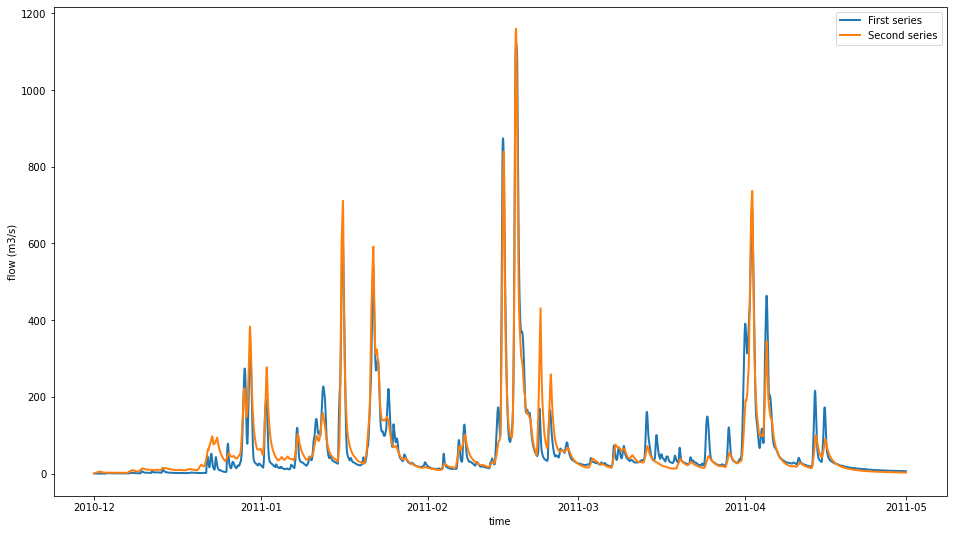

In [8]:
sViz = mk_date(2010,12,1)
eViz = mk_date(2011,4,30,23)

def subsetPlot(tts):
    from cinterop.timeseries import ts_window
    return ts_window(tts, from_date=sViz, to_date=eViz) 

def plot_obs_vs_calc(obs, calc, ylab="flow (m3/s)"):
    obs = subsetPlot(obs)
    calc = subsetPlot(calc)
    return plot_two_series(obs, calc, ylab=ylab, start_time = xr_ts_start(calc), end_time = xr_ts_end(calc))

p.apply_sys_config(simulation)
simulation.exec_simulation()
catchmentOutflowNoReservoir = simulation.get_recorded(flowId)
plot_obs_vs_calc(flowRateTs, catchmentOutflowNoReservoir)

### Set up the reservoir model

The catchment is simple, with node 2 being the outlet of the catchment so this is where we will add the reservoir

In [9]:
simulation.get_node_ids(), simulation.get_node_names()

(['2', '1'], ['Outlet', 'Node_1'])

We create a synthetic, simple LVA geometry for this vignette.

In [10]:
simulation.set_reservoir_model('LevelVolumeAreaReservoir', nodeId)

In [11]:
import numpy as np

def seq(start, stop, by):
    import math
    assert by > 0
    n = int(math.floor( (stop - start + 1) / by ))
    return np.linspace(start=start, stop=(start+n*by-1), num=n)

In [12]:
seq(1, 6, 1)

array([1., 2., 3., 4., 5., 6.])

In [13]:
seq(1, 6-0.1, 1)

array([1., 2., 3., 4., 5.])

In [14]:
import numpy as np
levels = seq(start=10.0, stop=30, by=0.1)
volumes = (levels - 10) ** 3.1 * 17000
area = volumes * 0.0

In [15]:
fsv_height = 27.0

levels >= fsv_height

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [16]:
fsv_index = np.where(levels >= fsv_height)[0][0]

In [17]:
fsv = volumes[fsv_index]

simulation.set_reservoir_geometry(nodeId, levels, volumes, area)

We also create synthetic level-discharge relationships. These define the minimum and maximum outflow rates for a reservoir, given its current level. This is a generic way to capture the behavior of many reservoirs; the minimum discharge curve is typically capture the uncontrolled overspill. The maximum discharge curve is for the outflow rate with all outlets and spillway gates open. Specialisations of this reservoir (for instance as inheriting C++ classes) can then refine the behavior with additional rules on the controlled releases.  

In this example for the sake of simplicity we set up identical minimal and maximal curves. Let's say the reservoir spills above 27 metres, and between 20 and 27 the outflow rate is linear.

In [18]:
min_d_levels = seq(start=20, stop=fsv_height-0.01, by=0.1)
max_outlet_rate = 20
discharge = np.linspace( 1, len(min_d_levels), num=len(min_d_levels)) / len(min_d_levels) * max_outlet_rate
min_d_levels_spill = seq(start=fsv_height, stop=30, by=0.1)
discharge_spill = (min_d_levels_spill - fsv_height) ** 3.5 * 40 + max_outlet_rate


# from swift2.utils import c

min_d_levels = np.concatenate([min_d_levels, min_d_levels_spill])
discharge = np.concatenate([discharge, discharge_spill])

In [19]:
simulation.set_reservoir_min_discharge(nodeId, min_d_levels, discharge)
simulation.set_reservoir_max_discharge(nodeId, min_d_levels, discharge)

Let's see the resulting behavior of this storage

In [20]:
simulation.record_state(mk_full_data_id(nodeId, 'reservoir.Storage'))
simulation.record_state(mk_full_data_id(nodeId, 'reservoir.OutflowRate'))
simulation.record_state(mk_full_data_id(nodeId, 'reservoir.InflowRate'))

simulation.exec_simulation()

st = simulation.get_recorded(mk_full_data_id(nodeId, 'reservoir.Storage'))
st_gl = st / 1e6 # m3 to GL
hline = st_gl.copy()
hline[:] = fsv / 1e6
import matplotlib.pyplot as plt

In [21]:
from swift2.vis import plot_series

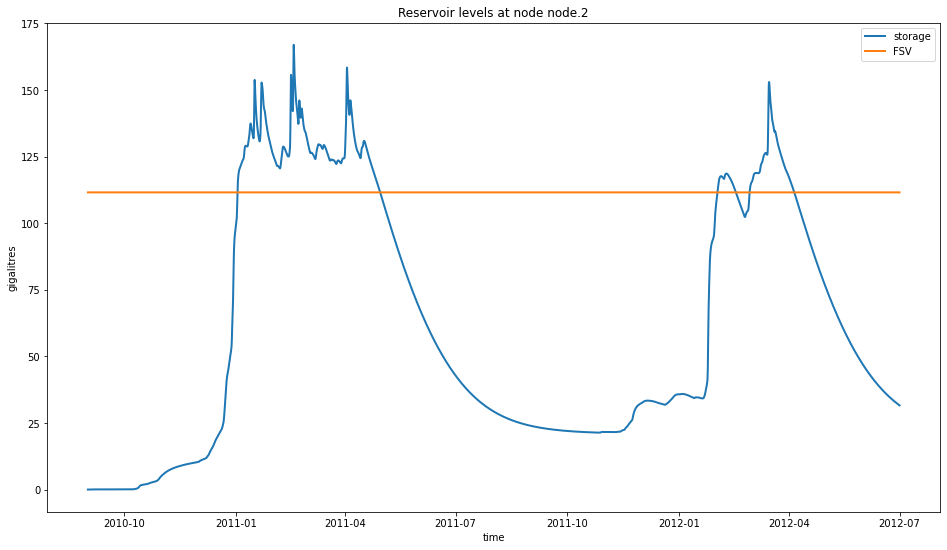

In [22]:
plot_two_series(st_gl, hline, names=['storage','FSV'], ylab='gigalitres', title=f"Reservoir levels at node {nodeId}")

In [23]:
catchmentOutflowWithReservoir = simulation.get_recorded(flowId)

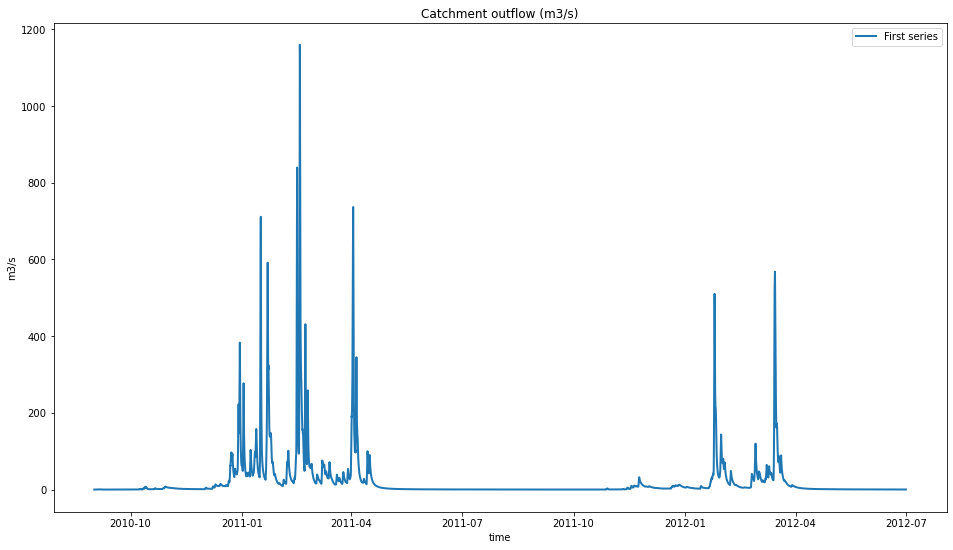

In [24]:
plot_series(catchmentOutflowNoReservoir, title="Catchment outflow (m3/s)", ylab="m3/s")

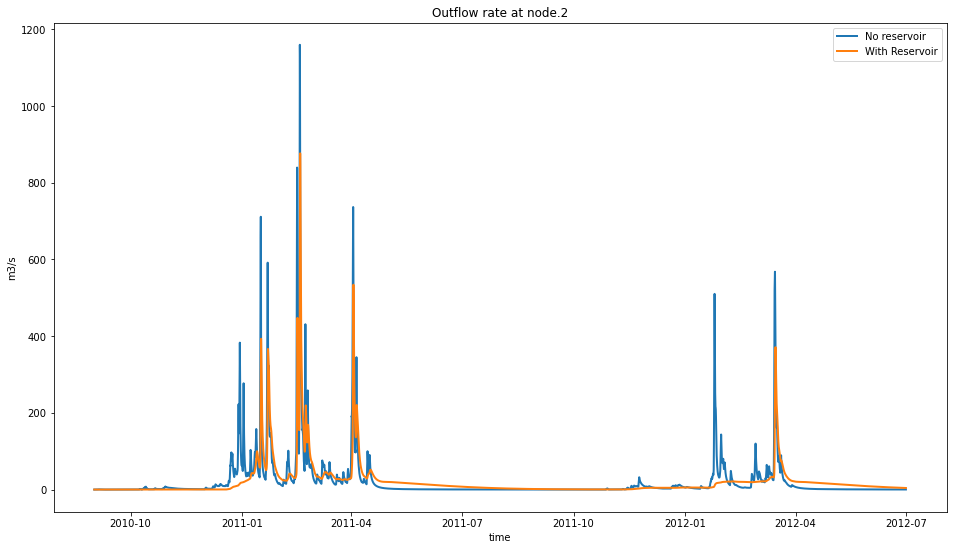

In [25]:
plot_two_series(catchmentOutflowNoReservoir, catchmentOutflowWithReservoir, 
                names=["No reservoir", "With Reservoir"], 
                ylab='m3/s', 
                title=f"Outflow rate at {nodeId}")

In [26]:
catchmentOutflowWithReservoir

<xarray.DataArray (variable_identifiers: 1, ensemble: 1, time: 16056)>
array([[[0.        , 0.        , 0.        , ..., 4.09947517,
         4.09481659, 4.0901634 ]]])
Coordinates:
  * ensemble              (ensemble) int64 0
  * time                  (time) datetime64[ns] 2010-09-01 ... 2012-06-30T23:...
  * variable_identifiers  (variable_identifiers) object 'node.2.OutflowRate'

In [27]:
# jsonFilePath = tempfile()
# SaveModelSimulationToJson_R(simulation, jsonFilePath)

# loaded_simulation = LoadModelSimulationFromJson_R(jsonFilePath)


# loaded_simulation.play_input(precipTs, mk_full_data_id('subarea', saId, hydroModelRainfallId))
# loaded_simulation.play_input(evapTs, mk_full_data_id('subarea', saId, hydroModelEvapId))
# simulation.set_simulation_time_step('hourly')
# simstart = mk_date(2010,9,1)  
# simend = mk_date(2012,6,30,23)  
# loaded_simulation.set_simulation_span(simstart, simend)

# loaded_simulation.record_state(mk_full_data_id(nodeId, 'reservoir.Storage'))
# loaded_simulation.exec_simulation()

# st_loaded = loaded_simulation.get_recorded(mk_full_data_id(nodeId, 'reservoir.Storage'))
# hline = st_loaded
# hline[:] = fsv
# plot(st_loaded, main='Reservoir volume m^3', ylab='m^3')
# lines(hline, col = "blue")

In [28]:
simulation.exec_simulation()

In [29]:
simulation.get_recorded(mk_full_data_id(nodeId, 'reservoir.Storage'))
orate = simulation.get_recorded(mk_full_data_id(nodeId, 'reservoir.OutflowRate'))
irate = simulation.get_recorded(mk_full_data_id(nodeId, 'reservoir.InflowRate'))

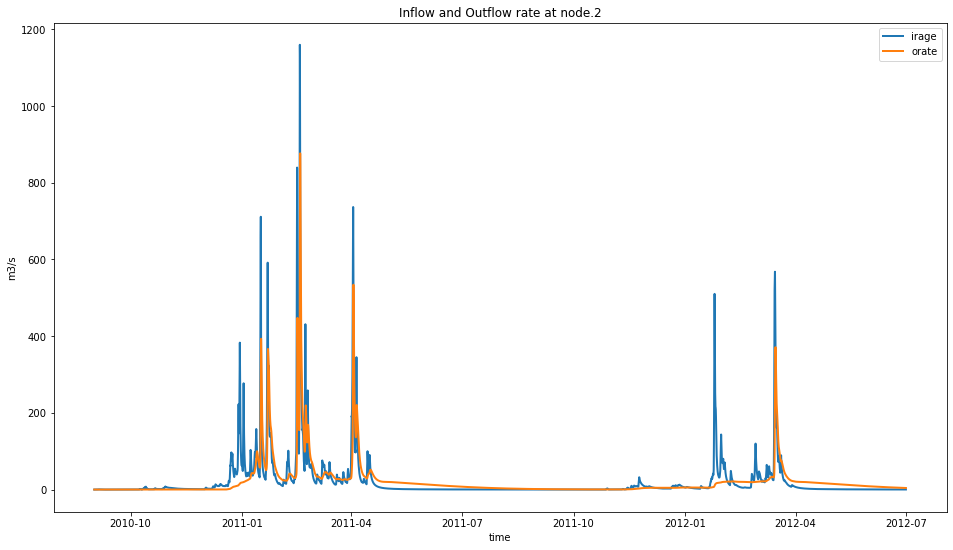

In [30]:
plot_two_series(irate, orate, 
                names=["irage", "orate"], 
                ylab='m3/s', 
                title=f"Inflow and Outflow rate at {nodeId}")